In [3]:
import numpy as np
#from numpy import linalg
import cupy as cp # need Python 3.11
from cupy import linalg
import matplotlib.pyplot as plt
import time
#-------------------------------------------------------------------------------------
# Check the current device
device = cp.cuda.Device()
print(f"Using device: {device}")  # Outputs something like "Device 0" if GPU is active
# Get device properties
props = cp.cuda.runtime.getDeviceProperties(0)
print(f"Device name: {props['name']}")

Using device: <CUDA Device 0>
Device name: b'NVIDIA GeForce MX450'


# free particle with initial state as a Gaussian wave packet

In [11]:
T = 0.1
Nscale = 30
L = Nscale*100*T
N = int(T * Nscale + 1)
M = int(L * Nscale)
x = cp.linspace(-L, L, M + 1)
dx = 2*L/M
dt = T/(N + 1)
#---------------------------------------------------------
time_seconds = np.log(N) * M**3 * 2.83e-10
hours = int(time_seconds // 3600)
minutes = int((time_seconds % 3600) // 60)
seconds = int(time_seconds % 60)
print(f'(T='+f'{T}'+', L='+f'{L}'+', M='+f'{M}'+', N='+f'{N}'+', (Nscale='+f'{Nscale}'+'))')
print(f"Estimated gpu time: {hours}h {minutes}min {seconds}s")

(T=0.1, L=300.0, M=9000, N=4, (Nscale=30))
Estimated gpu time: 0h 4min 46s


In [12]:
cp.cuda.Device().synchronize()
run_timea_start = time.time()
k0 = 1
m = 1
psi_0 = (2 / cp.pi)**(1/4) * cp.exp(- x**2 + 1j * k0 * x)

X_i, X_j = cp.meshgrid(x, x, indexing='ij')
K = (m / (2 * cp.pi * 1j * dt))**0.5 * cp.exp(1j * (m / 2 * (X_i - X_j)**2 / dt))

cp.cuda.Device().synchronize()
run_timeb_start = time.time()
KpowerN = cp.linalg.matrix_power(K, N+1)
cp.cuda.Device().synchronize()
run_timeb_end = time.time()

psi_final = dx**(N + 1) * KpowerN @ psi_0
cp.save('data/(T='+f'{T}'+', L='+f'{L}'+', M='+f'{M}'+', N='+f'{N}'+', (Nscale='+f'{Nscale}'+')) - psi_final_cpu.npy', psi_final)
cp.cuda.Device().synchronize()
run_timec_end = time.time()
print(f't/complexity = {(run_timeb_end-run_timeb_start)/(np.log(N) * M**3)}')
print(f'ta = {(run_timeb_start - run_timea_start)/60:.2f}min')
print(f'tb = {(run_timeb_end - run_timeb_start)/60:.2f}min')
print(f'tc = {(run_timec_end - run_timeb_end)/60:.2f}min')

t/complexity = 8.536552911639542e-10
ta = 0.07min
tb = 14.38min
tc = 0.02min


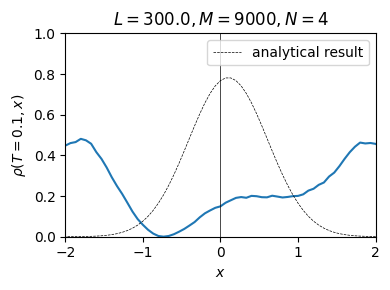

A = 3.116972 * 10^(11)


In [13]:
load = 0
if load == 0:
    psi_final = cp.asnumpy(cp.load('data/(T='+f'{T}'+', L='+f'{L}'+', M='+f'{M}'+', N='+f'{N}'+', (Nscale='+f'{Nscale}'+')) - psi_final_cpu.npy'))
else: # load == 1
    psi_final = cp.asnumpy(cp.load('data/(T=0.05, L=150.0, M=4500, N=2, (Nscale=30)) - psi_final_cpu.npy'))
    T=0.05
    L=150
    M=4500
    N=2

rho_final = (psi_final.real)**2 + (psi_final.imag)**2
xmax = 2
x = np.linspace(-L, L, M+1)
dx = 2*L/M
rho_renormalized = []
for i in range(len(psi_final)):
    if x[i] + dx > - xmax and x[i] - dx < xmax:
        rho_renormalized.append(rho_final[i])
    else:
        rho_renormalized.append(0)
rho_renormalized = np.array(rho_renormalized)
A = sum(rho_renormalized) * dx
rho_renormalized = rho_renormalized / A
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(x, rho_renormalized)
psi_analytically = (2/np.pi)**(1/4) * np.sqrt(m/(m + 1j * 2 * T)) * np.exp(m/(m + 1j * 2 * T) * (- x**2 + 1j * k0 * x) - 1j * k0**2 / (2 * (m + 1j * 2 * T)) * T)
rho_analytically = (psi_analytically.real)**2 + (psi_analytically.imag)**2
ax.plot(x, rho_analytically, linestyle='--', linewidth=0.5, color='black', label='analytical result')
ax.axvline(x=0, linestyle='-', linewidth=0.5, color='black')
ax.set_title('$L = '+f'{L}'+', M = '+f'{M}'+', N = '+f'{N}$')
ax.set_xlabel('$x$')
ax.set_ylabel('$\\rho(T = '+f'{T}'+', x)$')
ax.set_xlim(-xmax, xmax)
ax.set_ylim(0, 1)
ax.legend()
plt.tight_layout()
plt.savefig('path integral numerically (normalized) of a free particle with initial state as a Gaussian wave packet and T='+f'{T}'+' (L='+f'{L}'+', M='+f'{M}'+', N='+f'{N}'+').pdf', format='pdf')
plt.show()

Ascale = int(np.log(rho_final[int(M/2)])/np.log(10))
print(f'A = {(rho_final[int(M/2)] / 10**Ascale):1f} * 10^({Ascale})')